In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Cropping1D
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
n = 10
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Hat.mid
 [INFO] : 
 |  reading file: ../datasets/examples/02 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples/114_LetsDance_DavidBowie1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/127_SweetChildOMine_GunsAndRoses1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/92_GiveItAway_TheRedHotChiliPeppers.mid
 [INFO] : 
 |  reading file: ../datasets/examples/94_Creep_Radiohead2.mid
 [INFO] : 
 |  reading file: ../datasets/examples/bossa 1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/bossa 2.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182

In [5]:
n = 100
min_f = 3
max_f = 20
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9937500000000004
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.996875000000002
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.992708333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.992708333333335
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.993750000000003
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.021875000000001
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.004166666666672
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.001041666666666
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9968750000000006
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.058333333333333
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.009374999999998
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.991666666666668
 |>  150
 [DEBUG] > 
 |

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9937500000000044
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.032291666666668
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.99270833333333
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9916666666666685
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0145833333333343
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9979166666666655
 |>  150


In [9]:
y_train = x_train

In [10]:
x_train.shape

(271, 150, 1)

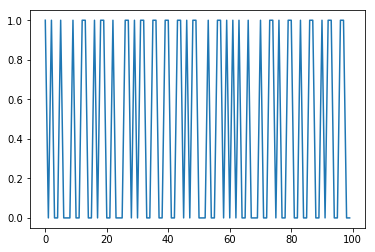

In [11]:
plt.plot(x_train[0,:100])

In [12]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(150, 1)

In [13]:
output_shape

(150, 1)

In [14]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
latent_dim = 100
# latent_dim = 1

In [160]:
# Define an input sequence and process it.
# encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_inputs = Input(shape=(input_shape[0], num_encoder_tokens))
# x = Dense(100)(encoder_inputs)
x = LSTM(latent_dim, return_sequences=True)(encoder_inputs)

# [Conv | Pooling]
#   strides => dimension reduction
x = Conv1D(latent_dim, kernel_size=2, strides=2, activation='relu')(x)
x = Conv1D(latent_dim * 2, kernel_size=2, strides=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Dense(latent_dim, activation='relu')(x)
x = Dense(latent_dim, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(latent_dim, activation='softmax')(x)
latent_length = keras.backend.int_shape(x)[1]
print('dims =', keras.backend.int_shape(x))

encoder_outputs = x
encoder_model = Model(encoder_inputs, encoder_outputs)

# timesteps = None | input_shape[0] | latent_length
decoder_inputs = Input(shape=(latent_length, latent_dim))
x = decoder_inputs
x = UpSampling1D(4)(x)
x = Conv1D(latent_dim, kernel_size=2, strides=1, activation='relu')(x)
x = Conv1D(int(latent_dim * 0.5), kernel_size=2, strides=1, activation='relu')(x)

x = UpSampling1D(4)(x)
x = Conv1D(latent_dim, kernel_size=2, strides=1, activation='relu')(x)
x = Conv1D(int(latent_dim * 0.5), kernel_size=2, strides=1, activation='relu')(x)

# imperfect parameter setup requires the need to crop the tensor
x = Cropping1D(cropping=(31, 1))(x)
# x = Dropout(0.1)(x)

x = LSTM(latent_dim, return_sequences=True, go_backwards=True)(x)
# x = Conv1D(100, 2, strides=2, activation='relu')(x)

# x = Dense(num_decoder_tokens * 100, activation='relu')(x)
# x = Dense(num_decoder_tokens * 100, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(num_decoder_tokens)(x)
decoder_outputs = x
decoder_model = Model(decoder_inputs, decoder_outputs)

model = Model(encoder_inputs, decoder_model(encoder_model(encoder_inputs)))
# model.summary()

dims = (None, 12, 100)


In [161]:
encoder_model.summary()
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       (None, 150, 1)            0         
_________________________________________________________________
lstm_112 (LSTM)              (None, 150, 100)          40800     
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 75, 100)           20100     
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 25, 200)           40200     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 12, 200)           0         
_________________________________________________________________
dense_307 (Dense)            (None, 12, 100)           20100     
_________________________________________________________________
dense_308 (Dense)            (None, 12, 100)           10100     
__________

In [162]:
metrics = ['accuracy','mse','binary_crossentropy']
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy'])#, metrics=metrics)

In [163]:
batch_size = 32
epochs = 15

In [164]:
callbacks = []
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
vs = 1/6
m = 100
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = model.fit(x_train[:m], x_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks)

Train on 83 samples, validate on 17 samples
Epoch 1/15
83/83 [==============================] - 11s 130ms/step - loss: 1.1861 - mean_squared_error: 0.2747 - mean_absolute_error: 0.3336 - acc: 0.6919 - val_loss: 0.6090 - val_mean_squared_error: 0.2047 - val_mean_absolute_error: 0.3487 - val_acc: 0.7322
Epoch 2/15
83/83 [==============================] - 1s 11ms/step - loss: 0.6405 - mean_squared_error: 0.2203 - mean_absolute_error: 0.3986 - acc: 0.6919 - val_loss: 0.6150 - val_mean_squared_error: 0.2118 - val_mean_absolute_error: 0.4489 - val_acc: 0.7353
Epoch 3/15
83/83 [==============================] - 1s 11ms/step - loss: 0.6495 - mean_squared_error: 0.2243 - mean_absolute_error: 0.4083 - acc: 0.6909 - val_loss: 0.5773 - val_mean_squared_error: 0.1942 - val_mean_absolute_error: 0.3956 - val_acc: 0.7322
Epoch 4/15
83/83 [==============================] - 1s 11ms/step - loss: 0.6143 - mean_squared_error: 0.2112 - mean_absolute_error: 0.4221 - acc: 0.6919 - val_loss: 0.5714 - val_mean_

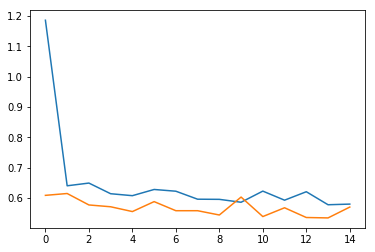

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

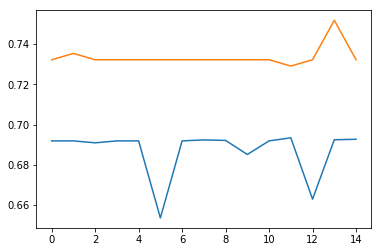

In [166]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

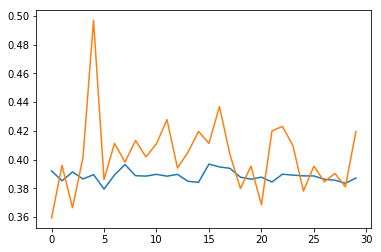

In [152]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

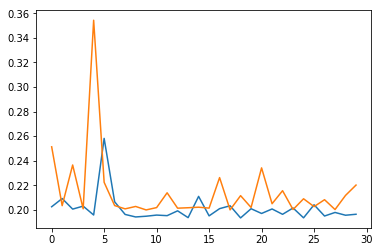

In [153]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

In [248]:
# plt.plot(history.history['binary_crossentropy'])
# plt.plot(history.history['val_binary_crossentropy'])

In [260]:
z = encoder_model.predict(x_train[:2])
z.shape

(2, 150, 64)

In [151]:
results = model.predict(x_train[:10])
results.shape

(10, 150, 1)

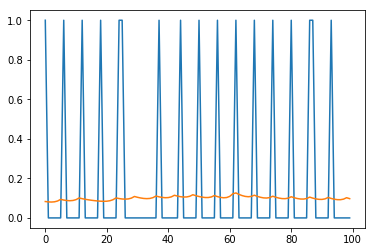

In [77]:
plt.plot(x_train[0,:100,:])
plt.plot(results[0,:100,:])

(0, 1)

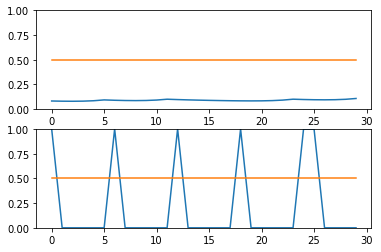

In [79]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

## Alt
Without teacher forcing https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html


<i>"In some niche cases you may not be able to use teacher forcing, because you don't have access to the full target sequences, e.g. if you are doing online training on very long sequences, where buffering complete input-target pairs would be impossible. In that case, you may want to do training by reinjecting the decoder's predictions into the decoder's input, just like we were doing for inference.

You can achieve this by building a model that hard-codes the output reinjection loop: "</i>

In [ ]:
from keras.layers import Lambda
from keras import backend as K

# The first part is unchanged
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)
states = [state_h, state_c]

# Set up the decoder, which will only process one timestep at a time.
decoder_inputs = Input(shape=(1, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# output will be a probability distribution over the vectors
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

all_outputs = []
inputs = decoder_inputs
max_decoder_seq_length = 100
for _ in range(max_decoder_seq_length):
    # Run the decoder on one timestep
    outputs, state_h, state_c = decoder_lstm(inputs,
                                             initial_state=states)
    outputs = decoder_dense(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define and compile model as previously
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Prepare decoder input data that just contains the start character
# Note that we could have made it a constant hard-coded in the model
decoder_input_data = np.zeros((x_train.shape[0], 1, num_decoder_tokens))

# Train model as previously
model.fit([x_train,y_train], z_train, epochs=10, batch_size=batch_size,
          validation_split=0.2, callbacks=callbacks)

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)